In [ ]:
%pip install requests pandas matplotlib sentence-transformers

In [2]:
article_aim = '''
The Journal of Artificial Intelligence Research (JAIR) is dedicated to the rapid dissemination of important 
research results to the global artificial intelligence (AI) community. The journal’s scope encompasses all 
areas of AI, including agents and multi-agent systems, automated reasoning, constraint processing and search, 
knowledge representation, machine learning, natural language, planning and scheduling, robotics and vision, 
and uncertainty in AI.
'''

In [ ]:
import time
import requests

CROSSREF_URL = "https://api.crossref.org/works"

def get_dois(
    issn: str,
    from_year: int,
    to_year: int,
    rows: int = 200,
    max_items: int = 400
):
    dois = []
    cursor = "*" 

    while True:
        params = {
            "filter": f"issn:{issn},from-pub-date:{from_year}-01-01,until-pub-date:{to_year}-12-31",
            "cursor": cursor,
            "rows": rows,
            "select": "DOI",
        }

        r = requests.get(CROSSREF_URL, params=params, timeout=60)

        msg = r.json().get("message", {})
        items = msg.get("items", [])
        if not items:
            break

        for it in items:
            doi = it.get("DOI")
            if doi:
                dois.append(doi.lower())

        dois = list(dict.fromkeys(dois))  
        print(f"DOIs collected so far: {len(dois)}")

        if len(dois) >= max_items:
            break

        next_cursor = msg.get("next-cursor")
        if not next_cursor or next_cursor == cursor:
            break

        cursor = next_cursor
        time.sleep(1.0)  

    return dois

In [ ]:
import os, time, json
import pandas as pd
import requests

PAPER_URL = "https://api.semanticscholar.org/graph/v1/paper/DOI:"
FIELDS = "paperId,title,abstract,year,venue,url"

headers = {}

def get_papers(doi: str, max_tries: int = 6):
    url = PAPER_URL + doi
    params = {"fields": FIELDS}

    for attempt in range(1, max_tries + 1):
        r = requests.get(url, params=params, headers=headers, timeout=60)

        if r.status_code == 200:
            return r.json()

        return None

    return None

def get_data(dois):
    rows = []
    checkpoint_path = "data/papers.jsonl"
    os.makedirs("data", exist_ok=True)

    # Getting loaded data
    seen = set()
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                seen.add(obj["doi"])
                rows.append(obj)
        print(f"Resuming from checkpoint: {len(rows)} rows already saved")

    if rows >= 400:
        return pd.DataFrame(rows).drop_duplicates(subset=["doi"])

    for i, doi in enumerate(dois, 1):
        if doi in seen:
            continue

        data = get_papers(doi)
        if data and data.get("abstract"):
            obj = {
                "doi": doi,
                "paperId": data.get("paperId"),
                "title": data.get("title"),
                "year": data.get("year"),
                "venue": data.get("venue"),
                "abstract": data.get("abstract"),
                "url": data.get("url"),
            }
            rows.append(obj)

            with open(checkpoint_path, "a", encoding="utf-8") as f:
                f.write(json.dumps(obj, ensure_ascii=False) + "\n")

        if i % 25 == 0:
            print(f"processed {i}/{len(dois)} DOIs, kept {len(rows)} with abstracts")

        time.sleep(0.15)

    return pd.DataFrame(rows).drop_duplicates(subset=["doi"])

In [6]:
ISSN = "1076-9757"
FROM_YEAR, TO_YEAR = 2019, 2026

dois = get_dois(ISSN, FROM_YEAR, TO_YEAR, rows=200, max_items=400)
print(f'len dois: {len(dois)}')

DOIs collected so far: 200
DOIs collected so far: 400
len dois: 400


In [8]:
df = get_data(dois)
print("Final papers with abstracts:", len(df))
df.head()

processed 25/400 DOIs, kept 20 with abstracts
processed 50/400 DOIs, kept 42 with abstracts
processed 75/400 DOIs, kept 65 with abstracts
processed 100/400 DOIs, kept 87 with abstracts
processed 125/400 DOIs, kept 110 with abstracts
processed 150/400 DOIs, kept 132 with abstracts
processed 175/400 DOIs, kept 153 with abstracts
processed 200/400 DOIs, kept 172 with abstracts
processed 225/400 DOIs, kept 189 with abstracts
processed 250/400 DOIs, kept 189 with abstracts
processed 275/400 DOIs, kept 189 with abstracts
processed 300/400 DOIs, kept 189 with abstracts
processed 325/400 DOIs, kept 189 with abstracts
processed 350/400 DOIs, kept 189 with abstracts
processed 375/400 DOIs, kept 189 with abstracts
processed 400/400 DOIs, kept 189 with abstracts
Final papers with abstracts: 189


,doi,paperId,title,year,venue,abstract,url
0,10.1613/jair.1.11323,f115aa4f8a788c6d154cd06dd75a2ba0254ce5e6,Rank Pruning for Dominance Queries in CP-Nets,2017,Journal of Artificial Intelligence Research,\n \n \nConditional preference networks (CP-ne...,https://www.semanticscholar.org/paper/f115aa4f...
1,10.1613/jair.1.11313,b409c375994dafa162e93d58f3bb1c1bfdf46569,Constraint and Satisfiability Reasoning for Gr...,2020,Journal of Artificial Intelligence Research,Graph coloring is an important problem in comb...,https://www.semanticscholar.org/paper/b409c375...
2,10.1613/jair.1.16580,a4ed37225481d39b0dbc92e5c29aa8be467532a2,Combinatorial Multi-Armed Bandits with Fairnes...,2025,Journal of Artificial Intelligence Research,The problem of multi-armed bandit (MAB) with f...,https://www.semanticscholar.org/paper/a4ed3722...
3,10.1613/jair.1.12136,9946aa012425820b6c6f14ad9158148f41bdb695,A Sufficient Statistic for Influence in Struct...,2019,Journal of Artificial Intelligence Research,Making decisions in complex environments is a ...,https://www.semanticscholar.org/paper/9946aa01...
4,10.1613/jair.1.13225,74b6da479001818d92d01f044886551c11bb8a25,Graph Kernels: A Survey,2019,Journal of Artificial Intelligence Research,Graph kernels have attracted a lot of attentio...,https://www.semanticscholar.org/paper/74b6da47...


In [ ]:
df = df[df["year"] >= 2019].copy()

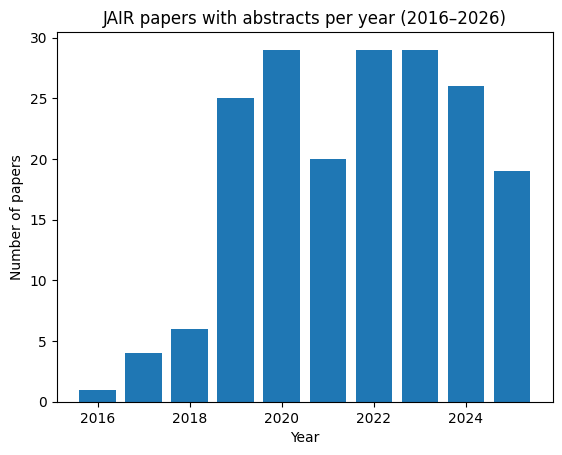

In [ ]:
import matplotlib.pyplot as plt

year_counts = df["year"].value_counts().sort_index()

plt.figure()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.show()

In [11]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

/Users/anarmammadov/Documents/UNIMI/NLP/Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [13]:
abstracts = df["abstract"].astype(str).tolist()

scope_emb = model.encode([article_aim], normalize_embeddings=True)
abs_embs  = model.encode(abstracts, normalize_embeddings=True, batch_size=32, show_progress_bar=True)

Batches: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


In [14]:
scores = (abs_embs @ scope_emb[0])  # shape: (num_papers,)
df["alignment_score"] = scores

df[["year", "title", "alignment_score"]].head()

,year,title,alignment_score
0,2017,Rank Pruning for Dominance Queries in CP-Nets,0.079710
1,2020,Constraint and Satisfiability Reasoning for Gr...,0.146243
2,2025,Combinatorial Multi-Armed Bandits with Fairnes...,0.194678
3,2019,A Sufficient Statistic for Influence in Struct...,0.368917
4,2019,Graph Kernels: A Survey,0.191099


In [15]:
df["alignment_score"].describe()

count    188.000000
mean       0.224060
std        0.089670
min        0.029163
25%        0.157316
50%        0.213812
75%        0.277603
max        0.433236
Name: alignment_score, dtype: float64

In [16]:
df.sort_values("alignment_score", ascending=False).head(5)[["year", "title", "alignment_score"]]

,year,title,alignment_score
92,2021,Ethics and Governance of Artificial Intelligen...,0.433236
114,2025,MA-LAMA: Exploiting the Multi-Agent Nature of ...,0.429931
19,2023,Viewpoint: Artificial Intelligence Accidents W...,0.429226
110,2020,Using Machine Learning for Decreasing State Un...,0.426861
143,2025,Computational Machine Ethics: A Survey,0.404478


In [17]:
df.sort_values("alignment_score", ascending=True).head(5)[["year", "title", "alignment_score"]]

,year,title,alignment_score
21,2019,Improving the Effectiveness and Efficiency of ...,0.029163
32,2025,Conditional Relative Frequency Distributions w...,0.059086
68,2021,Ordinal Maximin Share Approximation for Goods,0.063432
44,2020,The Complexity of Network Satisfaction Problem...,0.066254
94,2020,Structure from Randomness in Halfspace Learnin...,0.067724


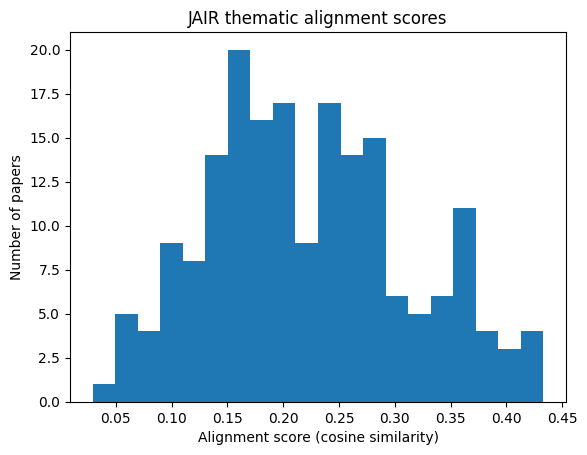

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["alignment_score"], bins=20)
plt.xlabel("Alignment score (cosine similarity)")
plt.ylabel("Number of papers")
plt.title("JAIR thematic alignment scores")
plt.show()

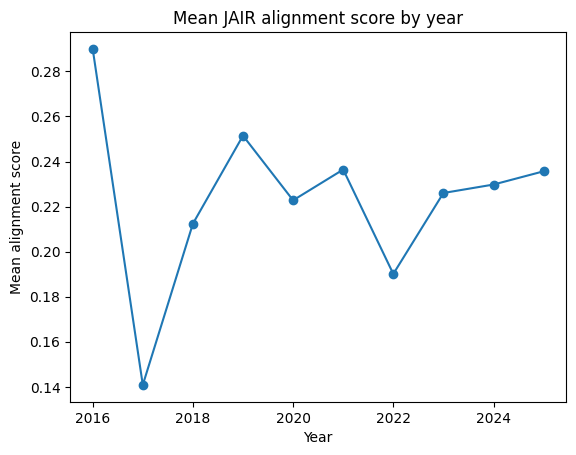

In [19]:
year_mean = df.groupby("year")["alignment_score"].mean().sort_index()

plt.figure()
plt.plot(year_mean.index, year_mean.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Mean alignment score")
plt.title("Mean JAIR alignment score by year")
plt.show()

In [20]:
# Top 5 most aligned papers
top5 = (
    df.sort_values("alignment_score", ascending=False)
      .head(5)[["year", "title", "alignment_score"]]
)

# Bottom 5 least aligned papers
bottom5 = (
    df.sort_values("alignment_score", ascending=True)
      .head(5)[["year", "title", "alignment_score"]]
)

top5, bottom5

(     year                                              title  alignment_score
 92   2021  Ethics and Governance of Artificial Intelligen...         0.433236
 114  2025  MA-LAMA: Exploiting the Multi-Agent Nature of ...         0.429931
 19   2023  Viewpoint: Artificial Intelligence Accidents W...         0.429226
 110  2020  Using Machine Learning for Decreasing State Un...         0.426861
 143  2025             Computational Machine Ethics: A Survey         0.404478,
     year                                              title  alignment_score
 21  2019  Improving the Effectiveness and Efficiency of ...         0.029163
 32  2025  Conditional Relative Frequency Distributions w...         0.059086
 68  2021      Ordinal Maximin Share Approximation for Goods         0.063432
 44  2020  The Complexity of Network Satisfaction Problem...         0.066254
 94  2020  Structure from Randomness in Halfspace Learnin...         0.067724)